### Extreme Event Case Study: October 2007 Santa Ana winds + wildfire
The *Historical Observations Data Platform* is a cloud-based, historical weather observations dataset that enables access to high-quality, rigorously quality-controlled open climate and weather data. The historical weather stations included in this dataset include information that can assess the severity, duration, frequency, and rate of change over time of extreme weather events, as well as supporting projections downscaling efforts. Stringent QA/QC procedures, in-line with international protocols, are applied with custom modifications relevant to the Western US and the energy sector are included (such as temperature and precipitation extremes, winds, and solar radiation). This notebook is a detailed investigation into how the QA/QC protocol performed during a known extreme event that stressed communities and the electric grid.

The event took place in the following counties:
- San Diego
- Los Angeles
- Ventura
- Santa Barbara
- San Bernardino
- Orange


variables of interest
- 'hurs' or 'hurs_derived' - relative humidity, derived
- 'sfcWind' - wind speed at 10m
- 'sfcWind_dir' - wind direction
- 'tas' - air temperature

In [13]:
# imports
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import sys  # Used for progress bar
from case_study_eval_utils import *
import datetime
import sys
import os

# Import qaqc stage plot functions
sys.path.append(os.path.abspath("../scripts/3_qaqc_data"))
from qaqc_plot import flagged_timeseries_plot, _plot_format_helper, id_flag


# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"

## Functions

In [21]:
def find_other_events(
    df, event_start, event_end, buffer=14, subset=None, return_stn_ids=True
):
    """
    Event finder not tied to specified case study events.

    Parameters
    ---------
    df : pd.DataFrame
        stationlist
    event_start : str
        start of event, format "YYYY-MM-DD"
    event_end : str
        end of event, format "YYYY-MM-DD"

    Returns
    -------
    eval_stns : pd.DataFrame
        subset of stations for other events of interest

    To dos
    ------
    1. Manual end date check no longer relevant, make sure stationlist passed is the correct updated version.
    2. Start / end date format check
    """

    print(
        f"Subsetting station record for event duration with {str(buffer)} day buffer..."
    )

    df["start-date"] = pd.to_datetime(df["start-date"])
    df["end-date"] = pd.to_datetime(df["end-date"])
    event_start = pd.to_datetime(event_start).tz_localize("UTC")
    event_end = pd.to_datetime(event_end).tz_localize("UTC")

    event_sub = df.loc[
        (df["start-date"] <= (event_start - datetime.timedelta(days=buffer)))
        & (df["end-date"] >= (event_end + datetime.timedelta(days=buffer)))
    ]

    # # exclude "manual check on end date" stations since we don't know when they actually end
    # event_sub = event_sub.loc[event_sub["notes"] != "manual check on end date"]

    # subset to make more manageable
    if subset != None:
        if len(event_sub) <= subset:
            eval_stns = event_sub
        else:
            eval_stns = event_sub.sample(subset, replace=False)
            print(f"{subset} stations selected for evaluation for comparison!")
    else:
        eval_stns = event_sub

    # return station ids for ease
    if return_stn_ids:
        print("Stations selected for evaluation:\n", list(eval_stns["era-id"]))

    return eval_stns

## Step 1: Subset the data

In [2]:
# set up event start and end dates, and affected counties
event_start_date = "2007-10-05"
event_end_date = "2007-11-30"
event_counties = ['San Diego','Los Angeles','Ventura','Santa Barbara','San Bernardino','Orange','Riverside']

In [3]:
# read in merge station list
stn_list = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

In [4]:
# convert it into geodataframe
stns_gdf = gpd.GeoDataFrame(
    stn_list,
    geometry=gpd.points_from_xy(
        stn_list.longitude, stn_list.latitude, crs="EPSG:4326"
    ),
)

In [5]:
# read in  CA county boundaries shapefile
ca_counties = gpd.read_file(
    "s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp"
)
ca_counties = ca_counties.to_crs(stns_gdf.crs)  # Convert to station CRS

In [6]:
# define the event geometry - we'll focus on once county for now (San Diego - where the largest fires occurred)
event_geom = ca_counties[ca_counties["NAME"] == ("San Diego")]  # .isin(event_counties)]

In [7]:
# filter down to stations that are in the target county
stns_gdf["intersects"] = stns_gdf.intersects(
    event_geom.unary_union
)  # See which stations intersect with the event polygon

event_stns = stns_gdf[stns_gdf["intersects"] == True].reset_index(
    drop=True
)  # Get just those stations, drop the others

In [8]:
# ...AND with start and end date within the event timeframe
event_stns = event_stns[
    (event_stns["start-date"] < event_end_date)
    & (event_stns["end-date"] > event_start_date)
]

In [9]:
# which stations are in there?
event_stns

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,pulled,time_checked,network,...,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs,qaqc,time_qaqc,merged,time_merge,geometry,intersects
0,76,ASOSAWOS_72293193107,32.8670,-117.1330,145.3896,2005-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,174010,131645,0,179796,Y,2025-05-20 16:02:43+00:00,Y,2025-06-12 18:36:24+00:00,POINT (-117.13300 32.86700),True
1,101,ASOSAWOS_74505653120,33.0380,-116.9160,422.1480,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,206978,113768,0,214563,Y,2025-05-01 19:47:04+00:00,Y,2025-06-12 18:47:36+00:00,POINT (-116.91600 33.03800),True
2,109,ASOSAWOS_72293453121,33.2190,-117.3500,9.1440,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,194657,108265,0,202377,Y,2025-05-01 19:39:51+00:00,Y,2025-06-12 18:30:06+00:00,POINT (-117.35000 33.21900),True
4,184,ASOSAWOS_72290303131,32.8150,-117.1370,127.4064,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,182809,128417,0,189378,Y,2025-05-01 19:38:39+00:00,Y,2025-06-12 18:30:08+00:00,POINT (-117.13700 32.81500),True
5,190,ASOSAWOS_72290753143,32.8260,-116.9730,32.8260,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-01-09 16:28:28+00:00,ASOSAWOS,...,198461,95915,0,209601,Y,2025-05-01 19:40:23+00:00,Y,2025-06-12 18:29:01+00:00,POINT (-116.97300 32.82600),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,14922,SGXWFO_SDUSS,32.8847,-117.2405,427.0000,2006-08-10 00:00:00+00:00,2010-10-21 21:00:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,23037,22816,0,23037,Y,2025-05-02 06:34:06+00:00,Y,2025-06-12 23:29:08+00:00,POINT (-117.24050 32.88470),True
496,14923,SGXWFO_SDIBS,32.5796,-117.1327,10.0000,2006-08-10 00:00:00+00:00,2009-12-01 19:00:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,18933,18211,0,18933,Y,2025-05-02 06:32:37+00:00,Y,2025-06-12 23:27:37+00:00,POINT (-117.13270 32.57960),True
497,14924,SGXWFO_SDIPR,32.5796,-117.1348,10.0000,2006-10-30 00:00:00+00:00,2009-12-01 19:00:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,18245,17945,0,18245,Y,2025-05-02 06:32:26+00:00,Y,2025-06-12 23:27:45+00:00,POINT (-117.13480 32.57960),True
498,14926,SGXWFO_SDPOY,32.9606,-117.0192,597.0000,2007-07-03 00:00:00+00:00,2013-09-12 14:52:00+00:00,Y,2023-03-22 00:06:47+00:00,SGXWFO,...,51579,41355,0,51580,Y,2025-05-02 06:33:41+00:00,Y,2025-06-12 23:28:56+00:00,POINT (-117.01920 32.96060),True


## Step 2: Investigate specific stations

In [127]:
url1 = f"s3://{BUCKET_NAME}/{MERGE_DIR}/SGXWFO/SGXWFO_SDUSS.zarr"

ds1 = xr.open_zarr(url1)

df1 = ds1.to_dataframe()
df1 = df1.reset_index()

In [128]:
df1.columns 

Index(['station', 'time', 'elevation', 'elevation_eraqc', 'hurs', 'hurs_eraqc',
       'lat', 'lon', 'pr_1h', 'pr_1h_eraqc', 'ps_altimeter',
       'ps_altimeter_eraqc', 'ps_derived', 'ps_derived_eraqc', 'sfcWind',
       'sfcWind_dir', 'sfcWind_dir_eraqc', 'sfcWind_eraqc', 'tas', 'tas_eraqc',
       'tdps_derived', 'tdps_derived_eraqc'],
      dtype='object')

In [129]:
subset1 = event_subset(df1, 'santa_ana_wind', 14)

Subsetting station record for event duration with 14 day buffer...


In [130]:
flags_during_event(subset1, "sfcWind", "santa_ana_wind")

Flags set on sfcWind during santa_ana_wind event: [nan]


[nan]

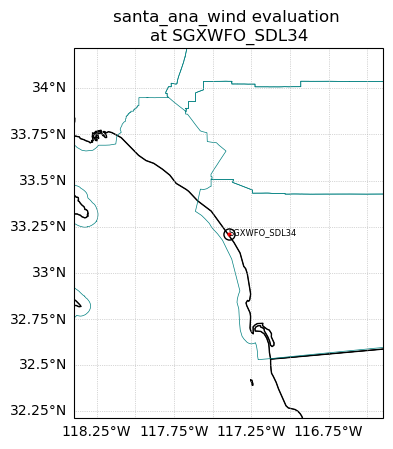

In [131]:
stn_visualize("SGXWFO_SDL34", stn_list, "santa_ana_wind")

In [ ]:
# filter the dataframe down to 2 weeks before and after the event window
mask = (df1["time"] >= "2007-10-05") & (df1["time"] <= "2007-11-30")
df_filt = df1.loc[mask]

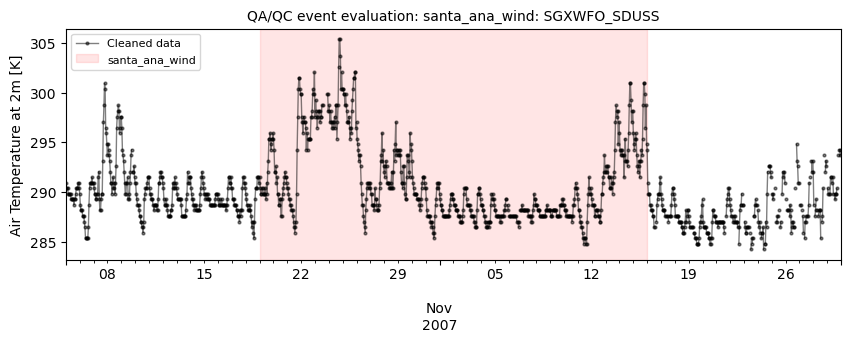

In [133]:
event_plot(df_filt, "tas", "santa_ana_wind")

In [88]:
# take a sub sample of stations
sub_sample = find_other_events(
    event_stns, event_start_date, event_end_date, 14, 5, return_stn_ids=True
)

Subsetting station record for event duration with 14 day buffer...
5 stations selected for evaluation for comparison!
Stations selected for evaluation:
 ['CWOP_AS654', 'CWOP_C7603', 'ASOSAWOS_72290693112', 'OtherISD_74718603164', 'ASOSAWOS_72292703177']


In [84]:
def id_flag(flag_to_id: int) -> str:
    """
    Identifies flag based on numerical value assigned for plotting.

    Parameters
    ----------
    flag_to_id : int
        specific flag to identify

    Returns
    -------
    fn_name : str
        name of QA/QC flag
    """

    flag_df = pd.read_csv("../data/era_qaqc_flag_meanings.csv")
    fn_name = flag_df.loc[flag_df["Flag_value"] == int(flag_to_id)][
        "QAQC_function"
    ].values[0]

    return fn_name

In [95]:
def event_plot_multiple_stations(
    sample: list,
    var: str,
    event: str,
    alt_start_date: str | None = None,
    alt_end_date: str | None = None,
    dpi: int | None = None,
):
    """Produces timeseries of variables that have flags placed

    Parameters
    ----------
    df : pd.DataFrame
        stationlist
    var : str
        name of variable
    event : str
        name of case study event
    alt_start_date : str
        date of different event, must be in format "YYYY-MM-DD"
    alt_end_date : str
        date of different event, must be in format "YYYY-MM-DD"
    dpi : int
        figure resolution

    Returns
    -------
    None
    """

    fig, ax = plt.subplots(figsize=(10, 3))

    # plot all observations
    for i in sample.index:
        station = sample.loc[i,"era-id"]
        network = sample.loc[i,"network"]

        url = f"s3://{BUCKET_NAME}/{MERGE_DIR}/{network}/{station}.zarr"

        ds = xr.open_zarr(url)

        df = ds.to_dataframe()
        df = df.reset_index()

        mask = (df["time"] >= "2007-10-05") & (df["time"] <= "2007-11-30")
        df = df.loc[mask]

        df.plot(
            ax=ax,
            x="time",
            y=var,
            marker=".",
            ms=4,
            lw=1,
            color="k",
            alpha=0.5,
            label=station,
        )


        # plot any flags placed by QA/QC
        if len(df[var + "_eraqc"].dropna().unique()) != 0:
            # identify flagged data, can handle multiple flags
            for flag in df[var + "_eraqc"].dropna().unique():
                flag_name = id_flag(flag)
                flag_str = 100 * len(df.loc[df[var + "_eraqc"] == flag, var]) / len(df)
                flag_label = f"{flag_str:.3f}% of data flagged by {flag_name}"

                flagged_data = df[~df[var + "_eraqc"].isna()]
                flagged_data.plot(
                    x="time",
                    y=var,
                    ax=ax,
                    #marker="o",
                    ms=7,
                    lw=0,
                    mfc="none",
                    color = np.random.rand(3,), #color="C3",
                    label=flag_label,
                )

    # plot event timeline
    event_start, event_end = event_info(event, alt_start_date, alt_end_date)
    ax.axvspan(
        event_start, event_end, color="red", alpha=0.1, label="{}".format(event)
    )
    legend = ax.legend(loc="upper left", prop={"size": 5})

    # plot aesthetics
    ylab, units, miny, maxy = _plot_format_helper(var)
    plt.ylabel(f"{ylab} [{units}]")
    plt.xlabel("")
    stn = df["station"].unique()[0]
    plt.title(
        f"QA/QC event evaluation: {event}: {stn}",
        fontsize=10,
    )

    return None

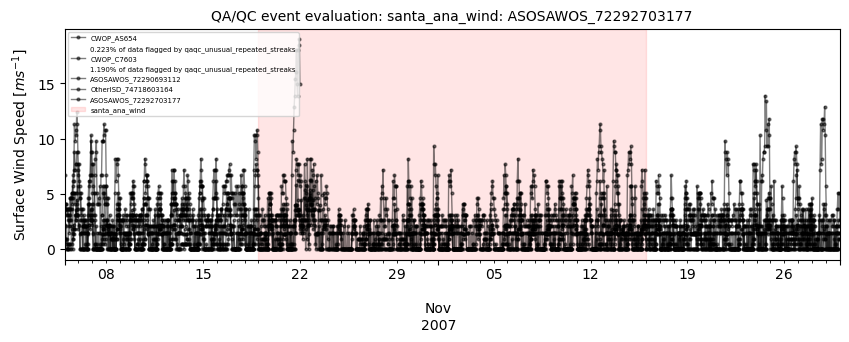

In [96]:
event_plot_multiple_stations(sub_sample, 'sfcWind', 'santa_ana_wind')

## Step 3:

In [ ]:
# some kind of map

In [ ]:
# table / stats "read out" on extremes during the event

In [ ]:
# table / stats "read out" on QC flags, including if we think refinement to QC tests would improve coverage

In [ ]:
# some function/thing in terms of how many stations "detected" the event

In [ ]:
# summary information via markdown close out of what we have learned